In [1]:
sample_image_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/rgb_test/2021_GRSM_5_267000_3942000_image.tif"
from deepforest import main
from deepforest import get_data
from deepforest import utilities
import matplotlib.pyplot as plt
import rasterio
import rasterio.features
import rasterio.warp
import os
model = main.deepforest()
model.use_release()

Reading config file: /home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [13]:


model = main.deepforest()
model.use_release()

sample_image = get_data(sample_image_path)

img = model.predict_tile(sample_image, return_plot = True, patch_size=500,patch_overlap=0.25)
plt.imsave(f"output3_patch_size=500_patch_overlap=0.25.png", img[:,:,::-1])

#predict_image returns plot in BlueGreenRed (opencv style), but matplotlib likes RedGreenBlue, switch the channel order. Many functions in deepforest will automatically perform this flip for you and give a warning.
# plt.imshow(img[:,:,::-1])
# plt.imsave(f"output2_patch_size=500_patch_overlap=0.1.png", img[:,:,::-1])

Reading config file: /home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 729/729 [00:15<00:00, 47.53it/s]
20346 predictions in overlapping windows, applying non-max supression
11628 predictions kept after non-max suppression


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/visualize.py:118: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/visualize.py:126: UserWarning: No color was provided and the label column is not numeric. Using a single default color.
  warnings.warn("No color was provided and the label column is not numeric. "


In [3]:
sample_image_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/rgb_test/2021_GRSM_5_267000_3942000_image.tif"

sample_image = get_data(sample_image_path)

predictions = model.predict_tile(sample_image, patch_size=500,patch_overlap=0.25)

with rasterio.open(sample_image_path) as df:
    transform = df.transform
    crs = df.crs
    gdf = utilities.annotations_to_shapefile(predictions, transform=transform, crs=crs)
    print(gdf.total_bounds)
    print(gdf.crs)
    # CRS.from_epsg(32617)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 729/729 [00:14<00:00, 50.76it/s]
20346 predictions in overlapping windows, applying non-max supression
11628 predictions kept after non-max suppression
[ 267294.65 3941999.95  268000.05 3942999.95]
PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/utilities.py:476: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be "


In [48]:

output_dir = "bounding_box_images"
os.makedirs(output_dir, exist_ok=True)
# Sort the dataframe by score and filter to top 500
gdf = gdf.sort_values(by="score", ascending=False)
gdf = gdf.head(500)


# Open the original image
with rasterio.open(sample_image_path) as src:
    # Loop through each bounding box in the gdf dataframe
    for index, row in gdf.iterrows():
        
        # Get the score of the bounding box
        score = row['score']
        # Get the bounding box coordinates
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

        # Create a rasterio window for the bounding box
        window=rasterio.windows.Window(xmin, ymin, xmax - xmin, ymax - ymin)

        # Read the subset of the image within the bounding box
        subset = src.read(window=window)



        # Create a new rasterio dataset for the subset
        subset_dataset = rasterio.open(
            f"{output_dir}/bounding_box_{index}_score={score}.tif",
            'w',
            driver='GTiff',
            height=subset.shape[1],
            width=subset.shape[2],
            count=subset.shape[0],
            dtype=subset.dtype,
            crs=src.crs,
            transform=src.window_transform(window)
        )
        
        # Write the subset to the new dataset
        subset_dataset.write(subset)
        subset_dataset.close()
        


In [188]:
from image import Image
sample_image_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/rgb_test/2021_GRSM_5_267000_3942000_image.tif"



In [189]:
img = Image(sample_image_path)

In [190]:
img.get_bounding_boxes()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 729/729 [00:14<00:00, 50.10it/s]
20346 predictions in overlapping windows, applying non-max supression
11628 predictions kept after non-max suppression


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/utilities.py:476: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be "


In [6]:
img.boxes

xmin    ymin    xmax    ymax label     score  \
0      8168.0  4029.0  8308.0  4167.0  Tree  0.874236   
1      6534.0  7912.0  6619.0  7997.0  Tree  0.873841   
2      5643.0  8251.0  5787.0  8380.0  Tree  0.863693   
3      8490.0  2625.0  8628.0  2760.0  Tree  0.848372   
4      9727.0  4130.0  9872.0  4275.0  Tree  0.843745   
...       ...     ...     ...     ...   ...       ...   
11623  9990.0  7964.0  9999.0  8000.0  Tree  0.100144   
11624  8351.0  4553.0  8374.0  4598.0  Tree  0.100057   
11625  6880.0     0.0  6922.0    29.0  Tree  0.100057   
11626  7226.0  8701.0  7250.0  8746.0  Tree  0.100024   
11627  4616.0  1982.0  4625.0  2027.0  Tree  0.100007   

                                 image_path  
0      2021_GRSM_5_267000_3942000_image.tif  
1      2021_GRSM_5_267000_3942000_image.tif  
2      2021_GRSM_5_267000_3942000_image.tif  
3      2021_GRSM_5_267000_3942000_image.tif  
4      2021_GRSM_5_267000_3942000_image.tif  
...                                     ...  
11623  2021_GRSM_5_267000_3942000_image.tif  
11624  2021_GRSM_5_267000_3942000_image.tif  
11625  2021_GRSM_5_267000_3942000_image.tif  
11626  2021_GRSM_5_267000_3942000_image.tif  
11627  2021_GRSM_5_267000_3942000_image.tif  

[11628 rows x 7 columns]

In [4]:
import h5py
sample_HSI_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/hsi_test/NEON_D07_GRSM_DP3_267000_3942000_reflectance.h5"
f = h5py.File(sample_HSI_path, 'r')

# data = f['image1']['image_data'][:,:]

In [36]:

reflectance_data =f['GRSM']['Reflectance']['Reflectance_Data'][:]



In [46]:
crs_hsi = f['GRSM']['Reflectance']['Metadata']['Coordinate_System']['Coordinate_System_String'][()]

In [42]:
img.crs

ERROR 1: PROJ: internal_proj_identify: /home/kmitchell/miniconda3/envs/micropheno/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [ ]:
b'PROJCS["UTM_Zone_17N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-81.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'
CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [191]:
from pyproj import CRS, Transformer

# Define the source and target CRS
rgb_crs = img.crs
hsi_crs = CRS.from_string(crs_hsi.decode('utf-8'))

# Create a transformer object
transformer = Transformer.from_crs(rgb_crs, hsi_crs)
# Create a new DataFrame to store the updated bounding box coordinates
hsi_boxes = img.boxes.copy()

# Iterate over each bounding box in img.boxes DataFrame
for index, row in img.boxes.iterrows():
    # Get the bounding box coordinates
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    
    # Perform the coordinate transformation
    hsi_xmin, hsi_ymin = transformer.transform(xmin, ymin)
    hsi_xmax, hsi_ymax = transformer.transform(xmax, ymax)
    
    # Update the bounding box coordinates in the new DataFrame
    hsi_boxes.at[index, 'xmin'] = hsi_xmin
    hsi_boxes.at[index, 'ymin'] = hsi_ymin
    hsi_boxes.at[index, 'xmax'] = hsi_xmax
    hsi_boxes.at[index, 'ymax'] = hsi_ymax


In [192]:
#read in phenogeo csv
import pandas as pd
phenogeo_csv = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/phenogeo.csv"
df = pd.read_csv(phenogeo_csv).dropna(subset=['adjDecimalLatitude', 'adjDecimalLongitude'])
df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_8735/4061787103.py:4: DtypeWarning: Columns (0,1,2,3,4,7,11,13,21,22,24,25,27,28,29,31,32,33,34,35,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,57,58,59,60,61,64,68,70,78,79,80,81,82,83,84,85,86,88,89,90,91,93,94,99,107,111,112,113,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(phenogeo_csv).dropna(subset=['adjDecimalLatitude', 'adjDecimalLongitude'])


In [174]:
rgb_crs

ERROR 1: PROJ: internal_proj_identify: /home/kmitchell/miniconda3/envs/micropheno/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

THIS ONE WORKS

In [301]:
from shapely.geometry import box
from pyproj import Transformer
import numpy as np
from scipy.spatial.distance import cdist
import numpy as np

# Create a transformer object
transformer = Transformer.from_crs(rgb_crs, 'EPSG:4326', always_xy=True, only_best=True)
meta_distances = []
# Iterate over each bounding box in img.gdf GeoDataFrame
for index, row in img.gdf.iterrows():
    # Get the polygon geometry
    polygon = row['geometry']
    
    # Get the centroid of the polygon
    centroid = polygon.centroid
    print(centroid.x, centroid.y)
    # Convert the centroid coordinates to latitude and longitude
    lon, lat = transformer.transform(centroid.x, centroid.y)
    
    # Append the centroid coordinates to the list
    centroid_coordinates = [(lat, lon)]
    
    # Convert the centroid coordinates to a numpy array
    centroid_array = np.array(centroid_coordinates)

    # Get the latitude and longitude columns from the df DataFrame
    latitude_longitude = df[['adjDecimalLatitude', 'adjDecimalLongitude']].values

    distances = cdist(centroid_array, latitude_longitude)
    closest_indices = np.argmin(distances, axis=1)

    # Get the closest latitude and longitude values from the df DataFrame
    closest_latitudes = df.loc[closest_indices, 'adjDecimalLatitude'].values
    closest_longitudes = df.loc[closest_indices, 'adjDecimalLongitude'].values
    

    print(f"Centroid of bounding box = {centroid_coordinates}")
    print(f"Closest Latitude = {closest_latitudes}, Closest Longitude = {closest_longitudes}")
    print(f"Distance to closest point = {min(distances[0,:])}")
    print("")
    meta_distances.append(min(distances[0,:]))


267823.8499999999 3942590.1500000004
Centroid of bounding box = [(35.59983823661384, -83.56291777513967)]
Closest Latitude = [35.6703531], Closest Longitude = [-83.58732506]
Distance to closest point = 0.07461944643557875

267657.70000000007 3942204.5
Centroid of bounding box = [(35.59632548798149, -83.56463931349516)]
Closest Latitude = [35.6703531], Closest Longitude = [-83.58732506]
Distance to closest point = 0.07742564641133354

267571.55 3942168.4
Centroid of bounding box = [(35.595980082315755, -83.56557901773681)]
Closest Latitude = [35.6703531], Closest Longitude = [-83.58732506]
Distance to closest point = 0.07748700795097387

267855.95 3942730.7000000007
Centroid of bounding box = [(35.60111177442788, -83.56260413656382)]
Closest Latitude = [35.6703531], Closest Longitude = [-83.58732506]
Distance to closest point = 0.07352200685178273

267980.0 3942579.7
Centroid of bounding box = [(35.59978074495468, -83.56119262557733)]
Closest Latitude = [35.66442722], Closest Longitude 

KeyboardInterrupt: 

In [296]:
df['adjNorthing'].head()

0    4.308580e+06
1    4.308580e+06
2    4.308580e+06
3    4.308580e+06
4    4.308580e+06
Name: adjNorthing, dtype: float64

In [294]:
min(meta_distances)

0.06983313063567818

In [263]:
from shapely.geometry import box
from pyproj import Transformer
import numpy as np

# Define the CRS for the pixel coordinates (assuming it's rgb_crs)
pixel_crs = rgb_crs

# Create a transformer object for pixel to UTM conversion
transformer_pix_to_utm = Transformer.from_crs(pixel_crs, 'EPSG:32617', always_xy=True, only_best=True)
# Create a transformer object for UTM to latlon conversion
transformer_utm_to_latlon = Transformer.from_crs('EPSG:32617', 'EPSG:4326', always_xy=True, only_best=True)

# Iterate over each bounding box in hsi_boxes DataFrame
for index, row in hsi_boxes.iterrows():
    # Get the bounding box coordinates in pixel coordinates
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    
    # Create a shapely box object
    bounding_box = box(xmin, ymin, xmax, ymax)
    
    # Find the centroid of the bounding box
    centroid = bounding_box.centroid
    
    # Convert the centroid coordinates to UTM
    pix_utm_x, pix_utm_y = transformer_pix_to_utm.transform(centroid.x, centroid.y)
    
    print(pix_utm_x, pix_utm_y)


8238.0 4098.0
6576.5 7954.5
5715.0 8315.5
8559.0 2692.5
9799.5 4202.5
8166.5 5968.0
5747.0 4208.0
9330.0 6791.5
6925.5 3851.0
6481.5 6412.5
9833.0 5118.5
4612.5 4213.0
5092.5 6429.5
7579.0 3080.5
6224.5 8542.0
9805.0 5690.5
8096.0 233.5
4580.0 4336.5
8699.0 3853.0
6185.0 5670.5
7524.0 4319.0
6497.5 6967.5
9935.0 7087.5
5304.0 5971.0
8761.0 7211.0
4761.0 2038.0
9231.5 6839.5
7201.5 9783.0
6804.5 3518.0
7564.0 3763.5
6459.0 1969.5
4728.0 9068.0
9417.0 6338.0
9193.0 6578.5
5714.5 455.5
6393.5 6202.5
7196.0 6201.0
9404.0 1148.5
6294.5 7219.5
5694.5 4330.5
7112.0 9895.5
4848.0 2692.0
7604.0 5995.5
9066.0 4540.0
3693.0 5675.0
5048.5 7498.5
6614.0 9856.0
5162.5 8317.0
4549.0 9558.0
9178.5 3437.0
5966.0 3831.5
6911.0 6537.5
8198.5 5668.5
5287.0 77.0
7841.5 2176.5
6045.0 3177.0
8668.5 1212.5
5986.5 8334.5
7026.5 4239.0
5407.0 8713.0
9936.0 5080.5
8272.0 2013.5
5405.0 5453.0
8974.0 4941.5
5597.0 7257.5
7658.0 4187.0
7290.5 5670.5
9453.5 5668.0
9292.0 1742.5
7867.5 4463.5
7252.0 6058.0
6047.0 961

In [279]:
img.boxes

xmin    ymin     xmax     ymax label     score  \
0      8168.0  4029.0   8308.0   4167.0  Tree  0.874236   
1      6534.0  7912.0   6619.0   7997.0  Tree  0.873841   
2      5643.0  8251.0   5787.0   8380.0  Tree  0.863693   
3      8490.0  2625.0   8628.0   2760.0  Tree  0.848372   
4      9727.0  4130.0   9872.0   4275.0  Tree  0.843745   
5      8123.0  5925.0   8210.0   6011.0  Tree  0.838390   
6      5709.0  4168.0   5785.0   4248.0  Tree  0.835918   
7      9283.0  6750.0   9377.0   6833.0  Tree  0.833254   
8      6887.0  3827.0   6964.0   3875.0  Tree  0.831677   
9      6428.0  6375.0   6535.0   6450.0  Tree  0.830756   
10     9795.0  5078.0   9871.0   5159.0  Tree  0.825253   
11     4571.0  4177.0   4654.0   4249.0  Tree  0.823765   
12     5043.0  6376.0   5142.0   6483.0  Tree  0.822219   
13     7539.0  3040.0   7619.0   3121.0  Tree  0.821692   
14     6161.0  8480.0   6288.0   8604.0  Tree  0.820965   
15     9738.0  5625.0   9872.0   5756.0  Tree  0.820664   
16     8051.0   189.0   8141.0    278.0  Tree  0.819423   
17     4517.0  4271.0   4643.0   4402.0  Tree  0.812580   
18     8653.0  3808.0   8745.0   3898.0  Tree  0.810740   
19     6140.0  5627.0   6230.0   5714.0  Tree  0.810404   
20     7457.0  4260.0   7591.0   4378.0  Tree  0.809731   
21     6431.0  6897.0   6564.0   7038.0  Tree  0.807343   
22     9880.0  7035.0   9990.0   7140.0  Tree  0.805853   
23     5252.0  5914.0   5356.0   6028.0  Tree  0.804627   
24     8719.0  7174.0   8803.0   7248.0  Tree  0.804219   
25     4702.0  1982.0   4820.0   2094.0  Tree  0.802777   
26     9195.0  6806.0   9268.0   6873.0  Tree  0.801552   
27     7134.0  9711.0   7269.0   9855.0  Tree  0.801302   
28     6739.0  3455.0   6870.0   3581.0  Tree  0.800014   
29     7508.0  3705.0   7620.0   3822.0  Tree  0.799112   
30     6421.0  1939.0   6497.0   2000.0  Tree  0.798952   
31     4676.0  9007.0   4780.0   9129.0  Tree  0.798618   
32     9378.0  6296.0   9456.0   6380.0  Tree  0.798076   
33     9137.0  6517.0   9249.0   6640.0  Tree  0.797964   
34     5637.0   380.0   5792.0    531.0  Tree  0.797142   
35     6324.0  6134.0   6463.0   6271.0  Tree  0.796915   
36     7148.0  6148.0   7244.0   6254.0  Tree  0.796863   
37     9377.0  1125.0   9431.0   1172.0  Tree  0.796669   
38     6255.0  7181.0   6334.0   7258.0  Tree  0.795914   
39     5643.0  4273.0   5746.0   4388.0  Tree  0.794988   
40     7062.0  9843.0   7162.0   9948.0  Tree  0.794535   
41     4786.0  2635.0   4910.0   2749.0  Tree  0.792337   
42     7563.0  5953.0   7645.0   6038.0  Tree  0.792248   
43     9000.0  4468.0   9132.0   4612.0  Tree  0.791393   
44     3670.0  5650.0   3716.0   5700.0  Tree  0.791279   
45     4995.0  7448.0   5102.0   7549.0  Tree  0.790702   
46     6558.0  9787.0   6670.0   9925.0  Tree  0.789888   
47     5125.0  8274.0   5200.0   8360.0  Tree  0.788065   
48     4499.0  9509.0   4599.0   9607.0  Tree  0.786427   
49     9115.0  3375.0   9242.0   3499.0  Tree  0.783646   
50     5924.0  3789.0   6008.0   3874.0  Tree  0.782797   
51     6835.0  6460.0   6987.0   6615.0  Tree  0.780538   
52     8166.0  5640.0   8231.0   5697.0  Tree  0.780445   
53     5251.0    44.0   5323.0    110.0  Tree  0.780425   
54     7804.0  2140.0   7879.0   2213.0  Tree  0.778192   
55     6007.0  3137.0   6083.0   3217.0  Tree  0.776595   
56     8626.0  1175.0   8711.0   1250.0  Tree  0.776484   
57     5925.0  8276.0   6048.0   8393.0  Tree  0.773794   
58     6981.0  4190.0   7072.0   4288.0  Tree  0.773049   
59     5367.0  8677.0   5447.0   8749.0  Tree  0.771697   
60     9877.0  5023.0   9995.0   5138.0  Tree  0.771649   
61     8203.0  1938.0   8341.0   2089.0  Tree  0.768804   
62     5346.0  5391.0   5464.0   5515.0  Tree  0.768201   
63     8933.0  4907.0   9015.0   4976.0  Tree  0.767601   
64     5535.0  7194.0   5659.0   7321.0  Tree  0.765977   
65     7599.0  4128.0   7717.0   4246.0  Tree  0.764801   
66     7244.0  5626.0   7337.0   5715.0  Tree  0.761301 

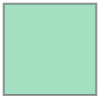

In [284]:
img.gdf['geometry'][0]

In [285]:
from shapely.geometry import Polygon
from pyproj import Transformer
import numpy as np

# Create a transformer object for pixel to UTM conversion
transformer_pix_to_utm = Transformer.from_crs(rgb_crs, 'EPSG:32617', always_xy=True, only_best=True)

# Iterate over each row in gdf
for index, row in img.gdf.iterrows():
    # Get the polygon geometry
    polygon = row['geometry']
    
    # Get the centroid of the polygon
    centroid = polygon.centroid
    
    # Convert the centroid coordinates to UTM
    pix_utm_x, pix_utm_y = transformer_pix_to_utm.transform(centroid.x, centroid.y)
    
    print(pix_utm_x, pix_utm_y)




267823.8499999999 3942590.1500000004
267657.70000000007 3942204.5
267571.55 3942168.4
267855.95 3942730.7000000007
267980.0 3942579.7
267816.7 3942403.1500000004
267574.75 3942579.1499999994
267933.05 3942320.8
267692.6 3942614.8500000006
267648.19999999995 3942358.700000001
267983.35000000003 3942488.0999999996
267461.30000000005 3942578.6500000004
267509.3 3942356.9999999995
267757.95 3942691.9
267622.50000000006 3942145.75
267980.54999999993 3942430.9000000004
267809.6500000001 3942976.6000000006
267458.05 3942566.2999999993
267869.94999999995 3942614.6500000004
267618.55 3942432.9
267752.45 3942568.05
267649.80000000005 3942303.2
267993.54999999993 3942291.2000000007
267530.45 3942402.8499999996
267876.14999999997 3942278.85
267476.15 3942796.15
267923.19999999995 3942316.0
267720.20000000007 3942021.6499999994
267680.5 3942648.15
267756.45 3942623.6
267645.95 3942803.0000000005
267472.85 3942093.1499999994
267941.75 3942366.15
267919.35 3942342.0999999996
267571.5 3942954.4
267639

In [220]:
img.image.shape

(10000, 10000)

In [230]:
df.head()

uid_x         namedLocation_x domainID_x  \
0  0cce2628-4f16-4181-8de9-f2982b0e2420  SCBI_060.phenology.phe        D02   
1  0cce2628-4f16-4181-8de9-f2982b0e2420  SCBI_060.phenology.phe        D02   
2  0cce2628-4f16-4181-8de9-f2982b0e2420  SCBI_060.phenology.phe        D02   
3  0cce2628-4f16-4181-8de9-f2982b0e2420  SCBI_060.phenology.phe        D02   
4  0cce2628-4f16-4181-8de9-f2982b0e2420  SCBI_060.phenology.phe        D02   

  siteID_x  plotID_x  decimalLatitude_x  decimalLongitude_x geodeticDatum_x  \
0     SCBI  SCBI_060          38.890173          -78.139772           WGS84   
1     SCBI  SCBI_060          38.890173          -78.139772           WGS84   
2     SCBI  SCBI_060          38.890173          -78.139772           WGS84   
3     SCBI  SCBI_060          38.890173          -78.139772           WGS84   
4     SCBI  SCBI_060          38.890173          -78.139772           WGS84   

   coordinateUncertainty_x  elevation_x  elevationUncertainty_x  \
0                      NaN        359.8                     NaN   
1                      NaN        359.8                     NaN   
2                      NaN        359.8                     NaN   
3                      NaN        359.8                     NaN   
4                      NaN        359.8                     NaN   

  subtypeSpecification_x  transectMeter_x directionFromTransect_x  \
0                primary            335.0                    Left   
1                primary            335.0                    Left   
2                primary            335.0                    Left   
3                primary            335.0                    Left   
4                primary            335.0                    Left   

   ninetyDegreeDistance_x  sampleLatitude_x  sampleLongitude_x  \
0                     1.0               NaN                NaN   
1                     1.0               NaN                NaN   
2                     1.0               NaN                NaN   
3                     1.0               NaN                NaN   
4                     1.0               NaN                NaN   

   sampleGeodeticDatum_x  sampleCoordinateUncertainty_x  sampleElevation_x  \
0                    NaN                            NaN                NaN   
1                    NaN                            NaN                NaN   
2                    NaN                            NaN                NaN   
3                    NaN                            NaN                NaN   
4                    NaN                            NaN                NaN   

   sampleElevationUncertainty_x      date_x editedDate_x  \
0                           NaN  2014-10-10   2020-07-14   
1                           NaN  2014-10-10   2020-07-14   
2                           NaN  2014-10-10   2020-07-14   
3                           NaN  2014-10-10   2020-07-14   
4                           NaN  2014-10-10   2020-07-14   

              individualID taxonID_x                        scientificName_x  \
0  NEON.PLA.D02.SCBI.06058      MIVI  Microstegium vimineum (Trin.) A. Camus   
1  NEON.PLA.D02.SCBI.06058      MIVI  Microstegium vimineum (Trin.) A. Camus   
2  NEON.PLA.D02.SCBI.06058      MIVI  Microstegium vimineum (Trin.) A. Camus   
3  NEON.PLA.D02.SCBI.06058      MIVI  Microstegium vimineum (Trin.) A. Camus   
4  NEON.PLA.D02.SCBI.06058      MIVI  Microstegium vimineum (Trin.) A. Camus   

   identificationQualifier_x taxonRank_x nativeStatusCode_x growthForm_x  \
0                        NaN     species                  I    Graminoid   
1                        NaN     species                  I    Graminoid   
2                        NaN     species                  I    Graminoid   
3                        NaN     species                  I    Graminoid   
4                        NaN     species                  I    Graminoid   

   vstTag_x samplingProtocolVersion_x                measuredBy_x  \
0       NaN         NEON.DOC.014040vM 